In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
IMG_SIZE = 224

In [3]:
path = "D:\Aj\\BirdClassification\\3rd method\\CNN3"
model_path = "D:\Aj\\BirdClassification\\Comparison of Models"
os.chdir(path)

In [4]:
tf.keras.utils.disable_interactive_logging()

# tf.keras.utils.enable_interactive_logging()

In [5]:
species = os.listdir(path + '/train/')
species = sorted(species)
len(species)

15

In [6]:
def pred_audio(path, filename):

    for root, _, files in os.walk(path + '/' + filename):
        os.chdir(root)
        file_list = os.listdir()
        bird_preds = []
        total_val = 0
        
        for file in file_list:
            img = load_img(file, target_size=(224, 224))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = x/255.0
            values = myModel.predict(x)
            total_val = total_val + values
            
        idx = np.argmax(total_val)
        predict = species[np.argmax(total_val)]

    return idx

<hr>

# Custom Model

In [7]:
myModel = keras.models.load_model(model_path + "/Model Bank/custom_model_15classes.h5")
path = 'D:\\Aj\\3rd method\\CNN'

In [11]:
import pickle

pickle_in = open("D:\\Aj\\3rd method\\X_test2.pickle", "rb")
X_test = pickle.load(pickle_in)

pickle_in = open("D:\\Aj\\3rd method\\y_test2.pickle", "rb")
y_test = pickle.load(pickle_in)

In [ ]:
_, valid_acc = myModel.evaluate(X_test, y_test, batch_size=16)
print(f"The validation accuracy is {valid_acc}")

In [8]:
IMG_SIZE

224

In [ ]:
valid_path = os.path.join(path, "validation")
true_vals = []
test_vals = []
species_idx = 0
start = 0
count = 0

for root,_,files in os.walk(valid_path):
    top1_count = 0
    top5_count = 0
    total_val = 0
    
    if root != valid_path:
        print(root)
        os.chdir(root)
        file_list = os.listdir()
        bird_preds = []
        
        for file in file_list:
            # print(file)
            img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = x/255.0
            values = myModel.predict(x)
            total_val = total_val + values
            idx = np.argmax(total_val)
            true_vals.append(species_idx)
            test_vals.append(idx)
        species_idx += 1
        
print('COMPLETE')

In [28]:
print(f'True Values: {len(true_vals)}\nTest Values: {len(test_vals)}')

True Values: 756
Test Values: 756


In [ ]:
species = os.listdir(valid_path)
species

In [ ]:
mat = confusion_matrix(true_vals, test_vals)
plot_confusion_matrix(mat, figsize=(15,15), class_names=species)
plt.show()

### TEST DATASET 1 (other audios from xenocanto)

In [9]:
test_path = os.path.join(path, "test")
species = os.listdir(test_path)
species = sorted(species)
species

['AsianGlossyStarling',
 'Black-crownedNightHeron',
 'Blue-tailedBee-eater',
 'BrownShrike',
 'CollaredKingfisher',
 'EurasianTreeSparrow',
 'GreyWagtail',
 'MangroveBlueFlycatcher',
 'Olive-backedSunbird',
 'PhilippineMagpie-Robin',
 'PhilippinePiedFantail',
 'PiedBushChat',
 'Red-keeledFlowerpecker',
 'White-breastedWaterhen',
 'Yellow-ventedBulbul']

In [10]:
species_index = 0
true_vals = []
test_vals = []

for root,_,files in os.walk(test_path):
    top1_count = 0
    top5_count = 0
    directory = os.path.split(root)
    
    if directory[-1] in species:
        print(directory[-1])
        folders = os.listdir(root)
        
        for folder in folders:
            print(folder)
            top_5 = []
            top_5_index = []
            total_values = 0
            second_total_values = 0
            
            os.chdir(os.path.join(root,folder))
            files = os.listdir()
            
            for file in files:
                img = load_img(file, target_size=(IMG_SIZE, IMG_SIZE))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = x/255.0
                values = myModel.predict(x)
                total_values += values
     
            total_values = total_values[0]
            top_idx = np.argmax(total_values)
            sorted_values = sorted(total_values, reverse=True)
            
            true_vals.append(species_index)
            test_vals.append(top_idx)
            
            ## For some instances where the current img file has a value of 1.0 then the next img file also has a value of 1.0 on another index.
            ## Solution is to append instantly the index and species name of the corresponding index/species name with 1.0 value
            ## It suggests that it is a 100% chance that the model predicted this bird from the current image.
            if 1.0 in sorted_values[:5]:
                count_1 = sorted_values[:5].count(1.0)
                if count_1 > 1:
                    for file in files:
                        img = load_img(file, target_size=(IMG_SIZE, IMG_SIZE))
                        x = img_to_array(img)
                        x = np.expand_dims(x, axis=0)
                        x = x/255.0
                        values = myModel.predict(x)
                        if 1.0 in values[0]:
                            top_5_index.append(int(np.where(values[0] == 1.0)[0]))
                            top_5.append(species[int(np.where(values[0] == 1.0)[0])])

            ## Some sorted values predict accurately(?) thus, having 0.0 values for the remaining ones
            ## e.g. [2.0, 1.8985287e-17, 5.6300662e-33, 0.0, 0.0, 0.0, 0.0, 0.0]
            ## This means that there is a 0% chance that the audio corresponds to the bird with 0.0 value
            ## Also, if there is a 1.0 value while predicting the individual images, check the top_5 list if there is already a value for it.
            ## If there is a value, get the length of the list then continue from the last one. Otherwise, continue normally
            if top_5 == []:
                for c in sorted_values[:5]:
                    if c == 0.0:
                        top_5.append("Others")
                    else:
                        top_5_index.append(int(np.where(total_values == c)[0]))
                        top_5.append(species[int(np.where(total_values == c)[0])])
            else:
                end = len(top_5)
                for c in sorted_values[end:5]:
                    if c == 0.0:
                        top_5.append("Others")
                    else:
                        top_5_index.append(int(np.where(total_values == c)[0]))
                        top_5.append(species[int(np.where(total_values == c)[0])])
                
            
            ## For the Top 1 count
            if species[top_idx] == species[species_index]:    
                top1_count += 1
            ## For the Top 5 count
            if species_index in list(top_5_index):
                top5_count += 1
                
            print(f'The top 5 species are: {top_5[0]}, {top_5[1]}, {top_5[2]}, {top_5[3]}, {top_5[4]}')

        print(f"Top 1 count: {top1_count} out of {len(folders)}")
        print(f"Top 5 count: {top5_count} out of {len(folders)}\n")
            
        species_index += 1

AsianGlossyStarling
135410.wav
The top 5 species are: MangroveBlueFlycatcher, AsianGlossyStarling, PhilippinePiedFantail, PiedBushChat, EurasianTreeSparrow
150616.wav
The top 5 species are: EurasianTreeSparrow, CollaredKingfisher, AsianGlossyStarling, PhilippinePiedFantail, PiedBushChat
150784.wav
The top 5 species are: CollaredKingfisher, EurasianTreeSparrow, PhilippinePiedFantail, BrownShrike, PiedBushChat
151125.wav
The top 5 species are: CollaredKingfisher, EurasianTreeSparrow, PiedBushChat, PhilippinePiedFantail, AsianGlossyStarling
203630.wav
The top 5 species are: CollaredKingfisher, PiedBushChat, BrownShrike, PhilippinePiedFantail, AsianGlossyStarling
297713.wav
The top 5 species are: PhilippinePiedFantail, CollaredKingfisher, AsianGlossyStarling, EurasianTreeSparrow, PiedBushChat
359561.wav
The top 5 species are: PhilippinePiedFantail, PiedBushChat, MangroveBlueFlycatcher, CollaredKingfisher, PhilippineMagpie-Robin
369053.wav
The top 5 species are: AsianGlossyStarling, Eurasia

TOP 5 ACCURACY: 

Custom Model 15 classes: 445/453 = 98.23%

Custom Model no birdfreq: 387/453 = 85.43%

In [11]:
print(f'True Values: {len(true_vals)}\nTest Values: {len(test_vals)}')

True Values: 453
Test Values: 453


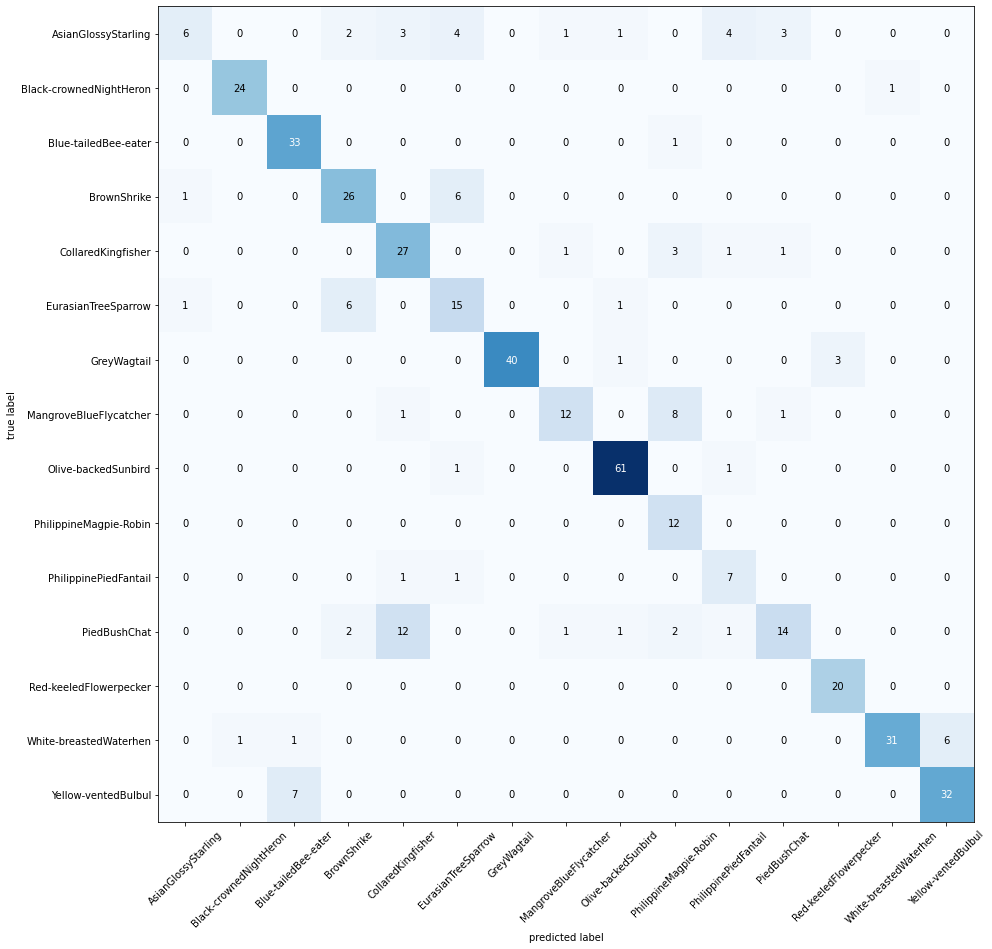

In [12]:
mat = confusion_matrix(true_vals, test_vals)
plot_confusion_matrix(mat, figsize=(15,15), class_names=species)
plt.show()

TOP 1 ACCURACY:

Custom Model 15 classes: 360/453= 79.47%

Custom Model no birdfreq: 252/453 = 55.63%

### TEST DATASET 2 (from AVoCET)

In [ ]:
test_path = os.path.join(path, "test2")

In [ ]:
species_index = 0
true_vals = []
test_vals = []

for root,_,files in os.walk(test_path):
    top1_count = 0
    top5_count = 0
    directory = os.path.split(root)
    
    if directory[-1] in species:
        print(directory[-1])
        folders = os.listdir(root)
        
        for folder in folders:
            print(folder)
            top_5 = []
            top_5_index = []
            total_values = 0
            second_total_values = 0
            
            os.chdir(os.path.join(root,folder))
            files = os.listdir()
            
            for file in files:
                img = load_img(file, target_size=(IMG_SIZE, IMG_SIZE))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = x/255.0
                values = myModel.predict(x)
                total_values += values
                    
            total_values = total_values[0]
            top_idx = np.argmax(total_values)
            sorted_values = sorted(total_values, reverse=True)
            
            true_vals.append(species_index)
            test_vals.append(top_idx)
            
            ## For some instances where the current img file has a value of 1.0 then the next img file also has a value of 1.0 on another index.
            ## Solution is to append instantly the index and species name of the corresponding index/species name with 1.0 value
            ## It suggests that it is a 100% chance that the model predicted this bird from the current image.
            if 1.0 in sorted_values[:5]:
                count_1 = sorted_values[:5].count(1.0)
                if count_1 > 1:
                    for file in files:
                        img = load_img(file, target_size=(IMG_SIZE, IMG_SIZE))
                        x = img_to_array(img)
                        x = np.expand_dims(x, axis=0)
                        x = x/255.0
                        values = myModel.predict(x)
                        if 1.0 in values[0]:
                            top_5_index.append(int(np.where(values[0] == 1.0)[0]))
                            top_5.append(species[int(np.where(values[0] == 1.0)[0])])

            ## Some sorted values predict accurately(?) thus, having 0.0 values for the remaining ones
            ## e.g. [2.0, 1.8985287e-17, 5.6300662e-33, 0.0, 0.0, 0.0, 0.0, 0.0]
            ## This means that there is a 0% chance that the audio corresponds to the bird with 0.0 value
            ## Also, if there is a 1.0 value while predicting the individual images, check the top_5 list if there is already a value for it.
            ## If there is a value, get the length of the list then continue from the last one. Otherwise, continue normally
            if top_5 == []:
                for c in sorted_values[:5]:
                    if c == 0.0:
                        top_5.append("Others")
                    else:
                        top_5_index.append(int(np.where(total_values == c)[0]))
                        top_5.append(species[int(np.where(total_values == c)[0])])
            else:
                end = len(top_5)
                for c in sorted_values[end:5]:
                    if c == 0.0:
                        top_5.append("Others")
                    else:
                        top_5_index.append(int(np.where(total_values == c)[0]))
                        top_5.append(species[int(np.where(total_values == c)[0])])
                
            
            ## For the Top 1 count
            if species[top_idx] == species[species_index]:    
                top1_count += 1
            ## For the Top 5 count
            if species_index in list(top_5_index):
                top5_count += 1
                
            print(f'The top 5 species are: {top_5[0]}, {top_5[1]}, {top_5[2]}, {top_5[3]}, {top_5[4]}')

        print(f"Top 1 count: {top1_count} out of {len(folders)}")
        print(f"Top 5 count: {top5_count} out of {len(folders)}\n")
            
        species_index += 1

TOP 5 ACCURACY: 

Custom Model 15 classes: 144/149 = 96.64%

Custom Model no birdfreq: 131/149 = 87.92%

In [ ]:
print(f'True Values: {len(true_vals)}\nTest Values: {len(test_vals)}')

In [ ]:
mat = confusion_matrix(true_vals, test_vals)
plot_confusion_matrix(mat, figsize=(15,15), class_names=species)
plt.show()

TOP 1 ACCURACY:

Custom Model 15 classes: 119/149 = 79.87%

Custom Model no birdfreq: 80/149 = 53.69%

<hr>

# Summary

__INCEPTIONV3 25 EPOCHS IMG_SIZE=299__

    Test Dataset 1

        Top 5 Accuracy: 95.80% 

        Top 1 Accuracy: 68.07%

    Test Dataset 2

        Top 5 Accuracy: 95.71% 

        Top 1 Accuracy: 70%

__INCEPTIONV3 100 EPOCHS__

    Test Dataset 1

        Top 5 Accuracy: 90.21% 

        Top 1 Accuracy: 59.21%

    Test Dataset 2

        Top 5 Accuracy: 87.86% 

        Top 1 Accuracy: 60.71%

__MOBILENETV2 100 EPOCHS__ 

    Test Dataset 1

        Top 5 Accuracy: 91.61% 

        Top 1 Accuracy: 56.41%

    Test Dataset 2

        Top 5 Accuracy: 91.43% 

        Top 1 Accuracy: 60.71%
        
__Custom Model 25 EPOCHS 14 CLASSES__ 

    Test Dataset 1

        Top 5 Accuracy: 98.37%  ***

        Top 1 Accuracy: 79.72%  ***

    Test Dataset 2

        Top 5 Accuracy: 98.57%  ***

        Top 1 Accuracy: 83.57%  ***
        
***Highest Accuracy

# Pre-trained Networkds 15 CLASSES

In [11]:
import tensorflow_hub as hub

In [8]:
# InceptionV3
# myModel = keras.models.load_model(model_path + "/InceptionV3/inceptionv3_15classes.h5")

# InceptionResNetV2
# myModel = keras.models.load_model(model_path + "/InceptionResNetV2/inceptionresnetv2_15classes.h5")

# MobileNetV3Small
# myModel = keras.models.load_model(model_path + "/MobileNetV3Small/mobilenetv2small_15classes2.h5")

# VGG19
# myModel = keras.models.load_model(model_path + "/VGG19/vgg19.h5")

# Xception
# myModel = keras.models.load_model(model_path + "/Xception/xception_15classes.h5")

# ResNetV2_50
# myModel = tf.keras.models.load_model(
#        model_path + "/resnetv2_50/resnetv2_50.h5",
#        custom_objects={'KerasLayer':hub.KerasLayer}
# )

# EfficientNetV2B0
# myModel = tf.keras.models.load_model(model_path + "/efficientnetv2b0/efficientnetv2b0.h5", custom_objects={'KerasLayer':hub.KerasLayer})

# Custom Model
myModel = keras.models.load_model("D:\\Aj\\BirdClassification\\3rd test dataset\\Model Bank\\custom model\\custom_model_nopreprocessinput.h5")

In [9]:
path = "D:\Aj\\BirdClassification\\3rd method\\CNN2"
train_path = "D:\Aj\\BirdClassification\\3rd method\\CNN2\\train"
valid_path = "D:\Aj\\BirdClassification\\3rd method\\CNN2\\validation"

IMG_SIZE = 224

In [10]:
species = os.listdir(path + '/test/')
species = sorted(species)
len(species)

15

### TEST DATASET 1 (other audios from xenocanto)

In [34]:
test_path = "D:\Aj\\BirdClassification\\3rd method\\CNN\\test\\"

In [35]:
species_index = 0

true_vals = []
test_vals = []

for root,_,files in os.walk(test_path):
    top1_count = 0
    top5_count = 0
    directory = os.path.split(root)
    
    if directory[-1] in species:
        print(directory[-1])
        folders = os.listdir(root)
        
        # Per folder
        for folder in folders:
            print(folder)
            top_5 = []
            total_values = 0
            os.chdir(os.path.join(root,folder))
            files = os.listdir()
            
            # Files inside folder
            for file in files:
                img = load_img(file, target_size=(IMG_SIZE, IMG_SIZE))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = x/255.0
                values = myModel.predict(x)
                total_values += values
                
            total_values = total_values[0]
            top_idx = np.argmax(total_values)
            sorted_values = sorted(total_values, reverse=True)
            
            true_vals.append(species_index)
            test_vals.append(top_idx)
            
            for c in sorted_values[:5]:
                top_5.append(int(np.where(total_values == c)[0]))
            
            ## For the Top 1 count
            if species[top_idx] == species[species_index]:    
                top1_count += 1
            ## For the Top 5 count
            if species_index in list(top_5):
                top5_count += 1
                
            print(f'The top 5 species are: {species[top_5[0]]}, {species[top_5[1]]}, {species[top_5[2]]}, {species[top_5[3]]}, {species[top_5[4]]}')

        print(f"Top 1 count: {top1_count} out of {len(folders)}")
        print(f"Top 5 count: {top5_count} out of {len(folders)}\n")
            
        species_index += 1

AsianGlossyStarling
135410.wav
The top 5 species are: MangroveBlueFlycatcher, AsianGlossyStarling, PiedBushChat, PhilippinePiedFantail, Yellow-ventedBulbul
150616.wav
The top 5 species are: AsianGlossyStarling, PiedBushChat, EurasianTreeSparrow, Yellow-ventedBulbul, CollaredKingfisher
150784.wav
The top 5 species are: AsianGlossyStarling, EurasianTreeSparrow, PiedBushChat, PhilippinePiedFantail, CollaredKingfisher
151125.wav
The top 5 species are: AsianGlossyStarling, PhilippinePiedFantail, EurasianTreeSparrow, CollaredKingfisher, BrownShrike
203630.wav
The top 5 species are: AsianGlossyStarling, PiedBushChat, PhilippinePiedFantail, CollaredKingfisher, Olive-backedSunbird
297713.wav
The top 5 species are: PhilippinePiedFantail, PhilippineMagpie-Robin, AsianGlossyStarling, PiedBushChat, MangroveBlueFlycatcher
359561.wav
The top 5 species are: Red-keeledFlowerpecker, PhilippineMagpie-Robin, Yellow-ventedBulbul, PhilippinePiedFantail, Blue-tailedBee-eater
369053.wav
The top 5 species are:

TOP 5 ACCURACY: /453 = %

In [36]:
print(f'True Values: {len(true_vals)}\nTest Values: {len(test_vals)}')

True Values: 453
Test Values: 453


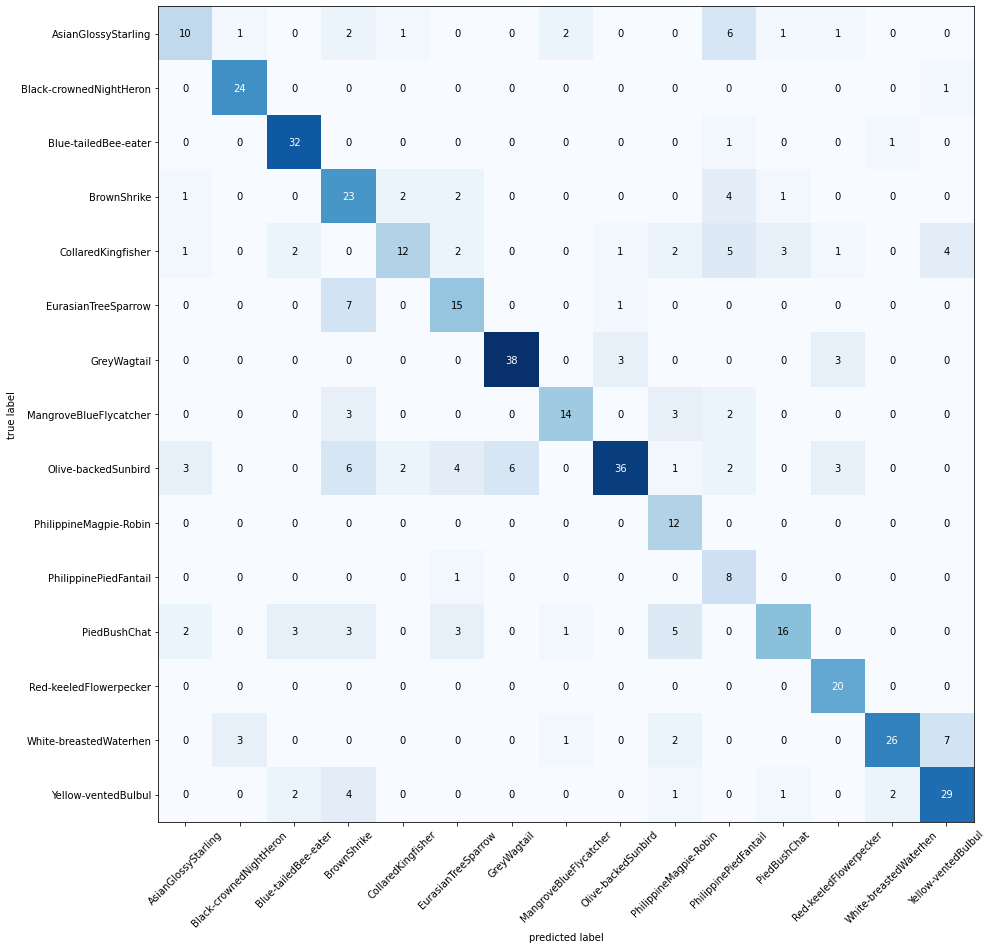

In [37]:
mat = confusion_matrix(true_vals, test_vals)
plot_confusion_matrix(mat, figsize=(15,15), class_names=species)
plt.show()

TOP 1 ACCURACY: 240/453 = 52.98%

### TEST DATASET 2 (from AVoCET)

In [38]:
test_path = "D:\\Aj\\BirdClassification\\3rd method\\CNN\\test2"
test_path

'D:\\Aj\\BirdClassification\\3rd method\\CNN\\test2'

In [39]:
species_index = 0

true_vals = []
test_vals = []

for root,_,files in os.walk(test_path):
    top1_count = 0
    top5_count = 0
    directory = os.path.split(root)
    
    if directory[-1] in species:
        print(directory[-1])
        folders = os.listdir(root)
        
        # Per folder
        for folder in folders:
            print(folder)
            top_5 = []
            total_values = 0
            os.chdir(os.path.join(root,folder))
            files = os.listdir()
            
            # Files inside folder
            for file in files:
                img = load_img(file, target_size=(IMG_SIZE, IMG_SIZE))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = x/255.0
                values = myModel.predict(x)
                total_values += values
                
            total_values = total_values[0]
            top_idx = np.argmax(total_values)
            sorted_values = sorted(total_values, reverse=True)
            
            true_vals.append(species_index)
            test_vals.append(top_idx)
            
            for c in sorted_values[:5]:
                top_5.append(int(np.where(total_values == c)[0]))
            
            ## For the Top 1 count
            if species[top_idx] == species[species_index]:    
                top1_count += 1
            ## For the Top 5 count
            if species_index in list(top_5):
                top5_count += 1
                
            print(f'The top 5 species are: {species[top_5[0]]}, {species[top_5[1]]}, {species[top_5[2]]}, {species[top_5[3]]}, {species[top_5[4]]}')

        print(f"Top 1 count: {top1_count} out of {len(folders)}")
        print(f"Top 5 count: {top5_count} out of {len(folders)}\n")
            
        species_index += 1

AsianGlossyStarling
AV10752_Aplonis+panayensis+panayensis_PH_1_0-28_C.wav
The top 5 species are: PhilippinePiedFantail, CollaredKingfisher, AsianGlossyStarling, PhilippineMagpie-Robin, EurasianTreeSparrow
AV10753_Aplonis+panayensis+panayensis_PH_1_0-124_C.wav
The top 5 species are: CollaredKingfisher, AsianGlossyStarling, PhilippinePiedFantail, PhilippineMagpie-Robin, MangroveBlueFlycatcher
AV12947_Aplonis+panayensis_SG_1_109-116_U.wav
The top 5 species are: EurasianTreeSparrow, BrownShrike, White-breastedWaterhen, GreyWagtail, AsianGlossyStarling
AV13667_Aplonis+panayensis_MY_1_0-17_C.wav
The top 5 species are: Olive-backedSunbird, AsianGlossyStarling, EurasianTreeSparrow, Blue-tailedBee-eater, PiedBushChat
AV15035_Aplonis+panayensis_PH_1_29-40_C.wav
The top 5 species are: PhilippinePiedFantail, AsianGlossyStarling, Olive-backedSunbird, PhilippineMagpie-Robin, GreyWagtail
AV15037_Aplonis+panayensis_PH_1_44-96_U.wav
The top 5 species are: PhilippinePiedFantail, PhilippineMagpie-Robin, 

TOP 5 ACCURACY: 

Custom Model 15 classes: 144/149 = 96.64%

Custom Model no birdfreq: 131/149 = 87.92%

In [40]:
print(f'True Values: {len(true_vals)}\nTest Values: {len(test_vals)}')

True Values: 149
Test Values: 149


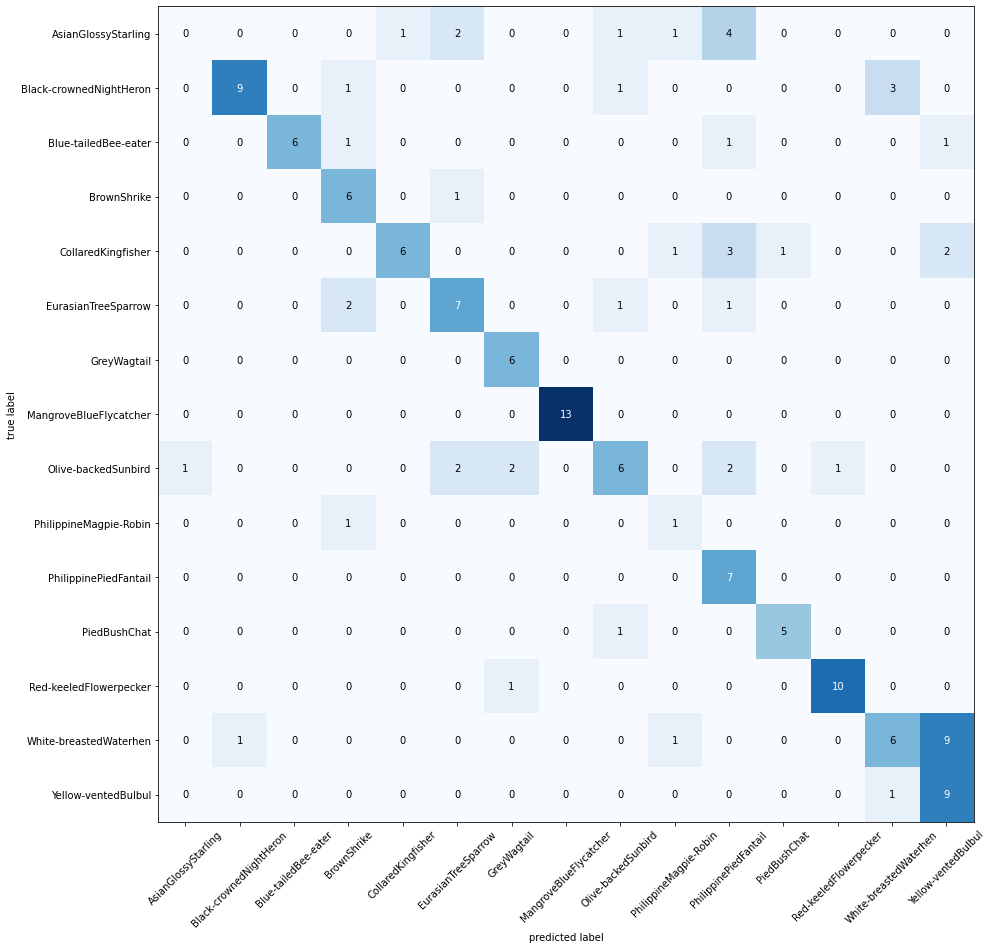

In [41]:
mat = confusion_matrix(true_vals, test_vals)
plot_confusion_matrix(mat, figsize=(15,15), class_names=species)
plt.show()

TOP 1 ACCURACY:

Custom Model 15 classes: 119/149 = 79.87%

Custom Model no birdfreq: 80/149 = 53.69%

<hr>